# Implementing the fun filters from AA228 on my own!
1. Extended Kalman Filter
2. Unscented Kalman Filter

With scenarios to generate data for the filters
   

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pprint import pprint
sys.path.append("../..")
from estimation.filtering.ekf import State, EkfParams, EKF
from PIL import Image
from dataclasses import dataclass
# from importlib import reload  # Python 3.4+



In [2]:
# State
example_state = State(1,np.diag([1,1,1]))
print(example_state)

State(x=1, P=array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]))


# Scenarios

## AA272 (GPS Class) HW4
(as per the HW notebook)




### Ekf Setup


State
$$
\mu_t := \begin{bmatrix} x_{t} & y_{t} & \theta_t \end{bmatrix}^\top,
$$

Input
$$
u_t := \begin{bmatrix} v_t & \alpha_t \end{bmatrix}^\top
$$

State transition
$$
\begin{aligned}
\mu_t &= f(\mu_{t-1}, u_{t}) + w_t, \\
&= \underbrace{\mu_{t-1} + \Delta t \begin{bmatrix} v_{t} \cos(\theta_{t-1}) \\ v_{t} \sin(\theta_{t-1}) \\ \alpha_{t} \end{bmatrix}}_{f(\mu_{t-1}, u_{t})} + w_t,
\end{aligned}
$$

In [3]:
def state_transition_model(state: np.ndarray, u: np.ndarray, dt: float):
    """
    Nominal state transition model
    
    Inputs:
        state: current state (3,) [x, y, theta]
        u_cur: current control input (2,) [v, alpha]
    Outputs:
        mu_next: next state (3,) [x, y, theta]
    """
    _,_,theta = state
    v,alpha = u

    return state + dt * np.array(
        [v*np.cos(theta), v*np.sin(theta), alpha]
    )


Measurements

$$
h^{(i)}(\mu_t) = \sqrt{(x^{(i)} - x_t)^2 + (y^{(i)} - y_t)^2},
$$

In [4]:
def measurement_model(state):
    """
    Measurement model
        Inputs:
            state: current state mean (3,) [x, y, theta]
        Outputs:
            z: measurement vector (4,) [d_1, d_2, d_3, d_4]
    """
    # Absolute beacon positions
    posb = 120
    xy_beacon = np.array([[-posb, posb], [posb, posb], [posb, -posb], [-posb, -posb]])
    
    z = np.zeros(4)
    x,y,_ = state

    for i, b in enumerate(xy_beacon):
        xb,yb = b
        z[i] = np.sqrt( (x - xb)**2 + (y - yb)**2 )

    return z

State transition and Measurement covariances
$$
\begin{aligned}
F(\mu_t, u_t) &= \begin{bmatrix} 1 & 0 & -\Delta t\ v_t sin(\theta_{t-1}) \\
    0 & 1 & \Delta t\ v_t cos(\theta_{t-1}) \\
    0 & 0 & 1 \end{bmatrix}
\end{aligned}
$$

$$
\begin{aligned}
H_t &= \begin{bmatrix}
\frac{2(x^1 - x_t)(-1)}{2 \sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
\frac{2(y^1 - y_t)(-1)}{2 \sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
0 \\
& \vdots & \\
\frac{2(x^4 - x_t)(-1)}{2 \sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
\frac{2(y^4 - y_t)(-1)}{2 \sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
0 \\
\end{bmatrix} \\ \\
&= \begin{bmatrix}
\frac{-(x^1 - x_t)}{\sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
\frac{-(y^1 - y_t)}{\sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
0 \\
& \vdots & \\
\frac{-(x^4 - x_t)}{\sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
\frac{-(y^4 - y_t)}{\sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
0 \\
\end{bmatrix} \\
\end{aligned}
$$

In [5]:
def get_F(state: np.ndarray, u: np.ndarray, dt: float):
    """Compute the Jacobian of the state transition model

    Args:
        state (np.ndarray): current state mean (3,) [x, y, theta]
        u (np.ndarray): current control input (2,) [v, alpha]

    Returns:
        F (np.ndarray): Jacobian matrix (3x3)
    """
    _,_,theta = state
    v,_ = u
    F = np.array([
      [1, 0, -dt * v * np.sin(theta)],
      [0, 1, dt * v * np.cos(theta)],
      [0, 0, 1]
    ])

    return F

def get_H(state: np.ndarray):
    """Compute the Jacobian of the measurement model

    Args:
        state (np.ndarray): current state mean (3,) [x, y, theta]

    Returns:
        H (np.ndarray): Jacobian matrix (4x3)
    """

    x,y,_  = state
    H = np.zeros((4,3))


    # distances from beacons
    xy_beacon = np.array([[-120, 120], [120, 120], [120, -120], [-120, -120]])

    # Did this the long way at first
    d1 = np.sqrt((x - xy_beacon[0][0])**2 + (y - xy_beacon[0][1])**2)
    d2 = np.sqrt((x - xy_beacon[1][0])**2 + (y - xy_beacon[1][1])**2)
    d3 = np.sqrt((x - xy_beacon[2][0])**2 + (y - xy_beacon[2][1])**2)
    d4 = np.sqrt((x - xy_beacon[3][0])**2 + (y - xy_beacon[3][1])**2)


    H = np.array([
        [(x - xy_beacon[0][0]) / d1, (y - xy_beacon[0][1]) / d1, 0],
        [(x - xy_beacon[1][0]) / d2, (y - xy_beacon[1][1]) / d2, 0],
        [(x - xy_beacon[2][0]) / d3, (y - xy_beacon[2][1]) / d3, 0],
        [(x - xy_beacon[3][0]) / d4, (y - xy_beacon[3][1]) / d4, 0],
    ])

    x_dist = x - xy_beacon[:,0]
    y_dist = y - xy_beacon[:,1]
    distances = np.sqrt(
        x_dist**2 + y_dist**2
    )

    H = np.vstack(
        ((x_dist / distances), (y_dist / distances), np.zeros(4))
    ).T

    return H

In [6]:
# Testing state covariances
dt = 1
# *** DO NOT MODIFY THE CODE BELOW ***
# For test (do not modify)
X_test1 = np.array([10, 30, np.pi/4])
u_test1 = np.array([5, 0.1])
F_test1 = get_F(X_test1, u_test1, dt)

X_test2 = np.array([20, -10, np.pi/6])
u_test2 = np.array([3, -0.2])
F_test2 = get_F(X_test2, u_test2, dt)

# for autograder
sol_35 = np.hstack([F_test1.flatten(), F_test2.flatten()])
print("State Transition Covariance Test\n   Result:", *np.round(sol_35, 2))
print("Should be: 1.0 0.0 -3.54 0.0 1.0 3.54 0.0 0.0 1.0 1.0 0.0 -1.5 0.0 1.0 2.6 0.0 0.0 1.0\n")

X_test1 = np.array([10, 30, np.pi/4])
H_test1 = get_H(X_test1)
X_test2 = np.array([20, -10, np.pi/6])
H_test2 = get_H(X_test2)
# for autograder
sol_36 = np.hstack([H_test1.flatten(), H_test2.flatten()])

print("Measurement Covariance Test\n   Result:", *np.round(sol_36, 2))
print("Should be: 0.82 -0.57 0.0 -0.77 -0.63 0.0 -0.59 0.81 0.0 0.65 0.76 0.0 0.73 -0.68 0.0 -0.61 -0.79 0.0 -0.67 0.74 0.0 0.79 0.62 0.0")

State Transition Covariance Test
   Result: 1.0 0.0 -3.54 0.0 1.0 3.54 0.0 0.0 1.0 1.0 0.0 -1.5 0.0 1.0 2.6 0.0 0.0 1.0
Should be: 1.0 0.0 -3.54 0.0 1.0 3.54 0.0 0.0 1.0 1.0 0.0 -1.5 0.0 1.0 2.6 0.0 0.0 1.0

Measurement Covariance Test
   Result: 0.82 -0.57 0.0 -0.77 -0.63 0.0 -0.59 0.81 0.0 0.65 0.76 0.0 0.73 -0.68 0.0 -0.61 -0.79 0.0 -0.67 0.74 0.0 0.79 0.62 0.0
Should be: 0.82 -0.57 0.0 -0.77 -0.63 0.0 -0.59 0.81 0.0 0.65 0.76 0.0 0.73 -0.68 0.0 -0.61 -0.79 0.0 -0.67 0.74 0.0 0.79 0.62 0.0


In [7]:
# Initializing envrironment 

def setup_gps_environment(
    delta_t: float = 1,  # time step
    Q = np.diag(np.array([0.1, 0.1, 0.01])),  # process noise covariance
    R = 10 * np.eye(4),  # measurement noise covariance
    seed = 0,  # random seed for reproducibility (do not change!!!)
    lent = 100,  # length of trajectory
    n_mc = 4,  # number of Monte Carlo simulations
    x0 = np.array([0, 0, 0])  # initial state [v_0, alpha, theta]
):
    # control input
    st = 5   # speed
    alpha = 0.1  # angular rate
    u_cur = np.array([st, alpha]) # current control input (2x1) [v_t, alpha]

    # set random seed
    np.random.seed(seed)

    env = {
        'delta_t': delta_t,
        'Q': Q,
        'R': R,
        'lent': lent,
        'n_mc': n_mc,
        'x0': x0,
        'u_cur': u_cur,
        'seed': seed
    }

    return env

env = setup_gps_environment()

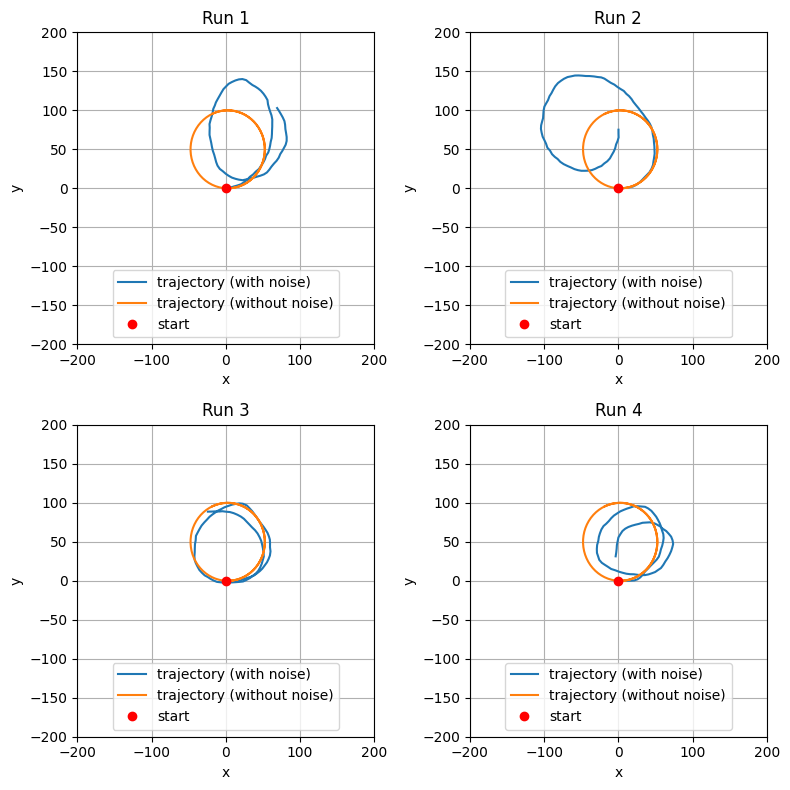

Should look like:


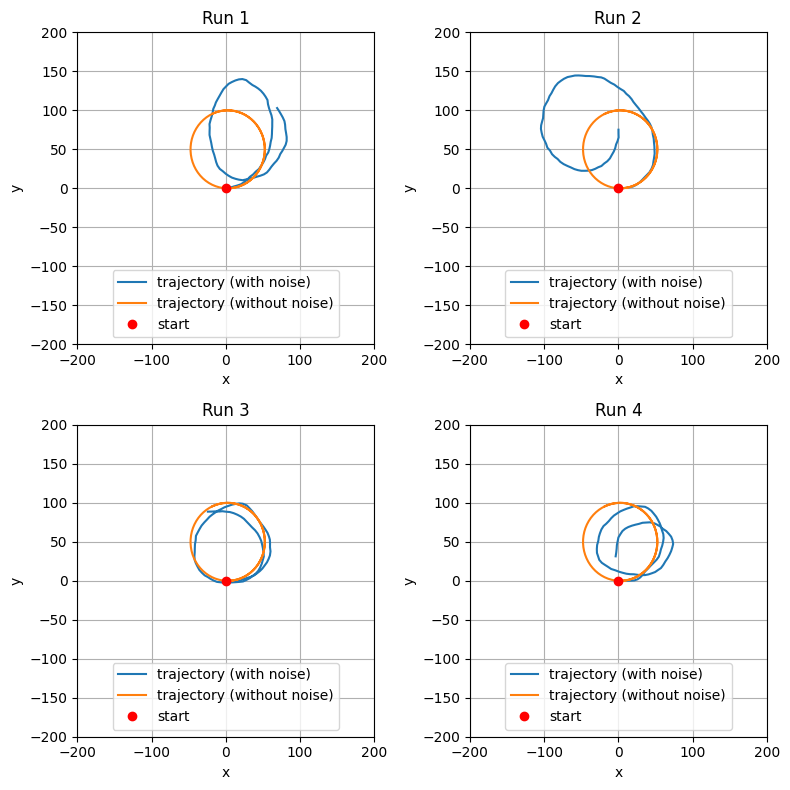

In [8]:
# Scenario from the AA272 (GPS) HW4 where 

# generate trajectories
def simulate_test_trajectories(env):
    """
    Simulate multiple trajectories with and without noise
    Outputs:
        X_true: true trajectory with noise (3 x lent x n_mc)
        X_nonoise: trajectory without noise (3 x lent)
    """
    lent = env['lent']
    n_mc = env['n_mc']
    u_cur = env['u_cur']
    Q = env['Q']
    x0 = env['x0']
    seed = env['seed']
    dt = env['delta_t']

    np.random.seed(seed)

    X_true = np.zeros((3, lent, n_mc))      # true trajectory with noise
    X_nonoise = np.zeros((3, lent))          # trajectory without noise

    # simulate no-noise trajectory
    for i in range(1, lent):
        X_cur = X_nonoise[:, i - 1]
        X_next = state_transition_model(X_cur, u_cur, dt)
        X_nonoise[:, i] = X_next

    # simulate noisy trajectory
    for mci in range(4):
        X_true[:, 0, mci] = x0

        for i in range(1, lent):
            X_cur = X_true[:, i - 1, mci]
            X_next = state_transition_model(X_cur, u_cur, dt) + np.random.multivariate_normal(np.zeros(3), Q)
            X_true[:, i, mci] = X_next

    return X_true, X_nonoise


def plot_trajectories(X_true, X_nonoise, n_mc, figsize=None):
    """
    Plot the simulated trajectories
    Inputs:
        X_true: true trajectory with noise (3 x lent x n_mc)
        X_nonoise: trajectory without noise (3 x lent)
        n_mc: number of Monte Carlo simulations
    Outputs:
        None
    """
    figsize = figsize if figsize else (8,8)
    plt.subplots(2, 2, figsize=figsize)

    for mci in range(n_mc):
        # plot the trajectory
        plt.subplot(2, 2, mci + 1)
        plt.plot(X_true[0, :, mci], X_true[1, :, mci], label='trajectory (with noise)')
        plt.plot(X_nonoise[0, :], X_nonoise[1, :], label='trajectory (without noise)')
        plt.plot(X_true[0, 0, mci], X_true[1, 0, mci], 'ro', label='start')
        plt.title('Run ' + str(mci + 1))
        plt.xlabel('x')
        plt.ylabel('y')
        # plt.axis('equal')
        plt.grid(True)
        plt.xlim([-200, 200])
        plt.ylim([-200, 200])
        plt.legend(loc='lower center')

    plt.tight_layout()
    plt.show()

# simulate and plot trajectories
X_true, X_nonoise = simulate_test_trajectories(env)
plot_trajectories(X_true, X_nonoise, env['n_mc'])

print("Should look like:")
Image.open('images/gps_traj_success.png')

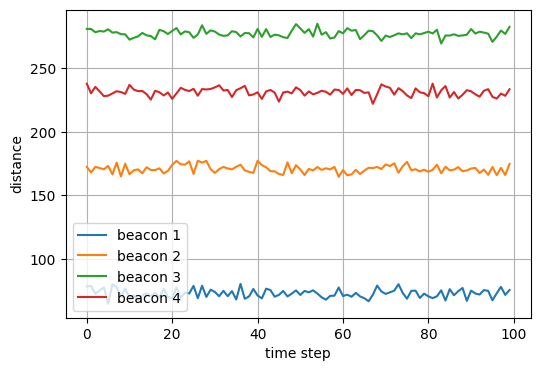

Should look like:


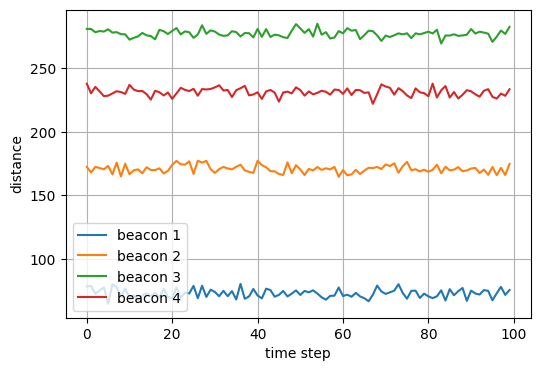

In [9]:
def simulate_measurements(pos, R, sim_num, seed=0):
   sim_num = 100
   z = np.zeros((4, sim_num))
   np.random.seed(seed)

   for i in range(sim_num):
      z[:, i] = measurement_model(pos) + np.random.multivariate_normal(np.zeros(4), R)

   return z

# plot the four measurements
def plot_measurements(z):
   sim_num = z.shape[1]
   plt.subplots(1, 1, figsize=(6, 4))
   plt.plot(np.arange(sim_num), z[0, :], label='beacon 1')
   plt.plot(np.arange(sim_num), z[1, :], label='beacon 2')
   plt.plot(np.arange(sim_num), z[2, :], label='beacon 3')
   plt.plot(np.arange(sim_num), z[3, :], label='beacon 4')
   plt.xlabel('time step')
   plt.ylabel('distance')
   plt.grid(True)
   plt.legend()
   plt.show()

# simulate noisy meas
pos = np.array([-50, 100, 0])
z = simulate_measurements(pos, env['R'], sim_num=100)
plot_measurements(z)

print("Should look like:")
Image.open('images/gps_noise_success.png')

### Data generation

In [ ]:
def generate_trajectory_gps(x0: np.ndarray, dt: float, u_cur: np.ndarray,
                            Q: np.ndarray, R: np.ndarray, lent: int, seed: int):
    """Simulate true (noisy) trajectory and measurements

    Args:
        x0 (np.ndarray): initial state (3,)
        dt (float): delta time
        u_cur (np.ndarray): current control input (2,)
        Q (np.ndarray): process noise covariance (3x3)
        R (np.ndarray): measurement noise covariance (4x4)
        lent (int): length of trajectory
        seed (int): seed

    Returns:
        (mu_true, Z_true): true trajectory (3 x lent) and measurements (4 x lent)
        
    """
    X_true = np.zeros((3, lent))
    z_true = np.zeros((4, lent))

    np.random.seed(seed)

    X_true[:, 0] = x0
    z_true[:, 0] = measurement_model(x0) + np.random.multivariate_normal(np.zeros(4), R)

    for t in range(1, lent):
        X_cur = X_true[:, t - 1]

        X_next = state_transition_model(X_cur, u_cur, dt) + np.random.multivariate_normal(np.zeros(3), Q)
        z_next = measurement_model(X_next) + np.random.multivariate_normal(np.zeros(4), R)

        X_true[:, t] = X_next
        z_true[:, t] = z_next

        # ****************************************************************
        # ****************************************************************

    return X_true, z_true

# X_true, z = generate_trajectory_gps(env["x0"], env["delta_t"], env["u_cur"], env["Q"], env["R"], env["lent"], env["seed"])


### EKF Testing Setup

In [11]:
# plot the estimated trajectory with truth
def plot_ekf_traj(X_true, X_hat, ax: plt.Axes):
    """
    Plot the EKF estimated trajectory with true trajectory
    Inputs:
        X_true: true trajectory (3 x lent)
        X_hat: estimated trajectory (3 x lent)
        z_true: measurements (4 x lent)
        ax: matplotlib axis
    Outputs:
        None
    """
    xy_beacon = np.array([[-120, 120], [120, 120], [120, -120], [-120, -120]])

    ax.plot(X_true[0, :], X_true[1, :], 'b-', label='true trajectory')
    ax.scatter(X_hat[0, :], X_hat[1, :], 10, color='red', label='estimated trajectory')
    ax.scatter(X_true[0, 0], X_true[1, 0], 50, marker='s', color='blue', label='true iniial position')
    ax.scatter(X_hat[0, 0], X_hat[1, 0], 50, marker='s', color='red', label='estimated initial position')
    # plot beacons
    for i in range(4):
        if i == 0:
            ax.plot(xy_beacon[i, 0], xy_beacon[i, 1], 'ko', label='beacons')
        else:
            ax.plot(xy_beacon[i, 0], xy_beacon[i, 1], 'ko')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(True)
    ax.legend(loc='lower center')

In [12]:
def run_ekf(ekf: EKF, u_cur: np.ndarray, X_true: np.ndarray, z_true: np.ndarray):
    """
    Run EKF over the entire trajectory

    Inputs:
        Q_ekf: process noise covariance (3x3)
        R_ekf: measurement noise covariance (4x4)
        u_cur: current control input (2,)
        X_true: true trajectory (3 x lent)
        z_true: measurements (4 x lent)
        P0: initial covariance (3x3)
    Outputs:
        mu_hat: estimated trajectory (3 x lent)
        P_hat: estimated covariance (3 x 3 x lent)
    """

    lent = X_true.shape[1]
    X_est = np.zeros((3, lent))
    P_est = np.zeros((3, 3, lent))
    P0 = ekf.state.P

    # initial estiamte
    X_est[:, 0] = X_true[:, 0] + np.random.multivariate_normal(np.zeros(3), ekf.state.P)
    P_est[:, :, 0] = P0

    for i in range(lent-1):

        ekf.predict(u_cur) # dt is used
        ekf.update(z_true[:, i+1])

        X_est[:, i+1] = ekf.state.x
        P_est[:, :, i+1] = ekf.state.P

    return X_est, P_est



def run_full_sim(env: dict, ekf: EKF, plot=True):
    """
    Run the EKF simulation and plot results
    Inputs:
        plot: whether to plot the results
    Outputs:
        mu_hat: estimated trajectory (3 x lent)
        P_hat: estimated covariance (3 x 3 x lent)
    """

    u_cur = env['u_cur']
    Q = env['Q']
    R = env['R']
    lent = env['lent']
    x0 = env["x0"]
    P0 = np.diag(np.array([25, 25, 1]))

    # simulate true trajectory and measurements
    n_mc = 4  # number of Monte Carlo simulations

    if plot:
        _, axs = plt.subplots(2, 2, figsize=(10, 10))

    for mci in range(n_mc):
        
        # Reset ekf
        ekf.state = State(x0, P0)

        # Run ekf
        X_true, z_true = generate_trajectory_gps(x0, env["delta_t"], u_cur, Q, R, lent, env["seed"] + 2*mci)
        X_hat, P_hat = run_ekf(ekf, u_cur, X_true, z_true)
        
        if plot:
            plot_ekf_traj(X_true, X_hat, axs[mci // 2, mci % 2])

    if plot:
        plt.tight_layout()
        plt.show()

    return X_hat, P_hat

### EKF Running

In [13]:

# simulate true trajectory and measurements
n_mc = 4  # number of Monte Carlo simulations
dt = env["delta_t"] # 1 seconds

# Noise
Q_ekf = np.diag(np.array([0.1, 0.1, 0.01]))
R_ekf = np.diag(np.array([10, 10, 10, 10]))

def f(x,u):
    return state_transition_model(x,u,dt)

def F(x,u):
    return get_F(x,u,dt)

ekf_params = EkfParams(
    f = f,
    F = F,
    h = measurement_model,
    H = get_H,
    Q = Q_ekf,
    R = R_ekf
)

P0 = np.diag(np.array([25, 25, 1]))
state0 = State(env['x0'], P0)

# EKF!
ekf = EKF(state0, ekf_params)

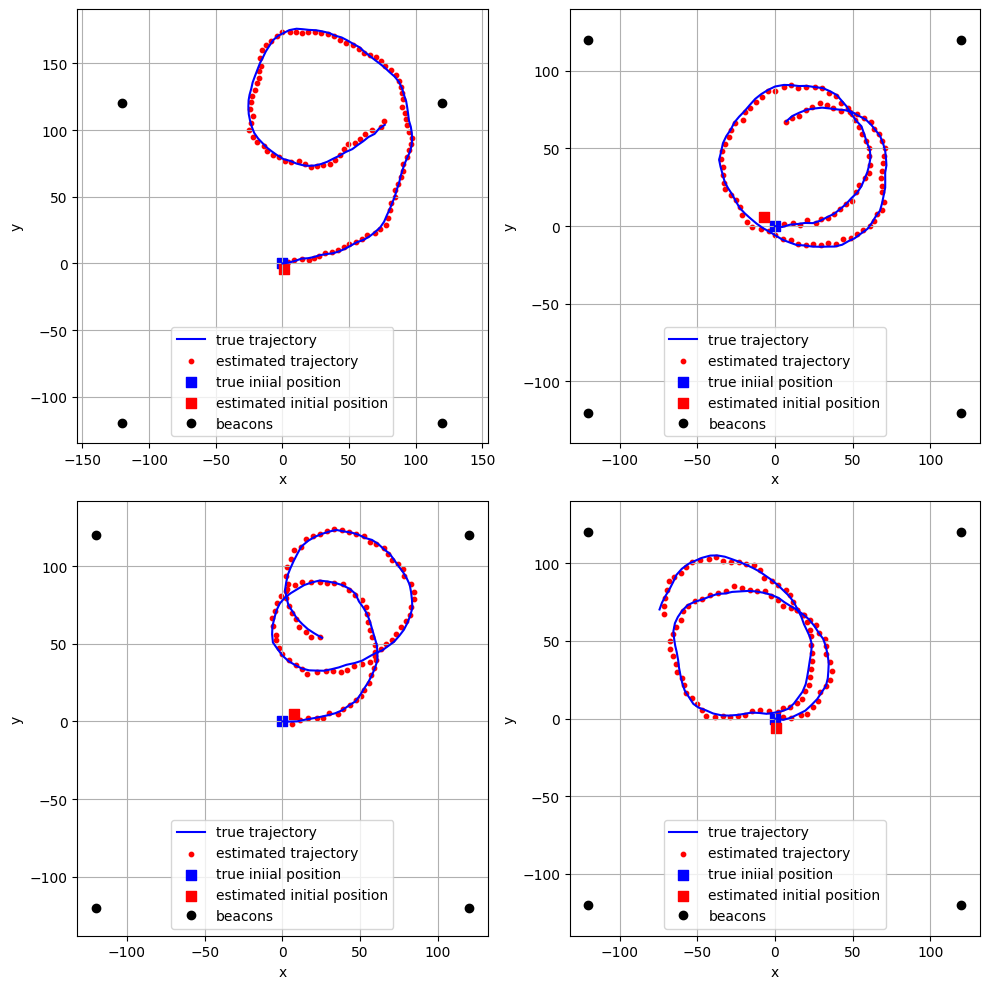

Should look like:


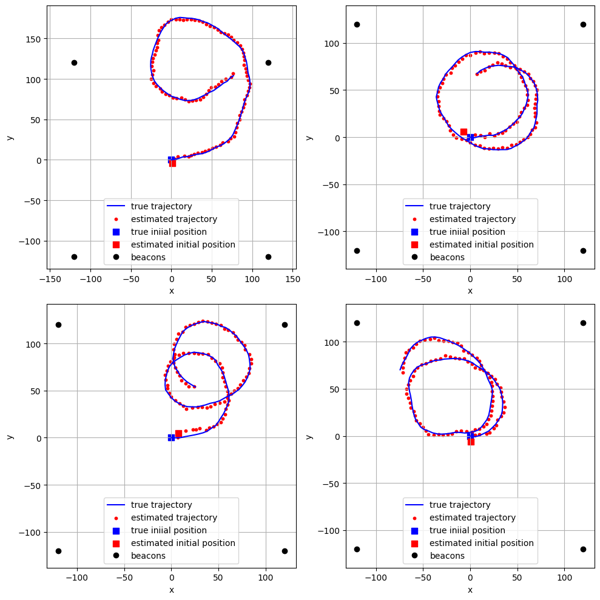

In [14]:
mu_hat, P_hat = run_full_sim(env, ekf, plot=True)

print("Should look like:")
img = Image.open("images/gps_ekf_run_success.png")
img.resize((600,600))


## AA 242A Cart with Pendulum (HW5)

This took forever to write out and derive but lowkey this was so fun

### Dynamics formulas

Going to use 

![image](./images/cart_spring_pendulum.png)

Deriving the equations of motion gives:

$$ \ddot{x}\ cos\phi + l \ddot{\phi} + g\ sin \phi = 0$$
$$ (m+M) \ddot{x} + m \ddot{\phi} l\ cos \phi - m \phi^2 l\ sin\phi + kx = 0 $$

which, for a state of $\mathbf{X} = [x, \phi, \dot{x}, \dot{\phi}]^\top$ gives (in a really non-simplified manner):

$$ \ddot{x} = \frac{mg\ sin\phi \cos\phi + m \dot{\phi}^2 l sin\phi - kx}{m + M - m cos^2 \phi} $$
$$ \ddot{\phi} = \frac{1}{l} \left[ \frac{
    mg\ sin\phi \cos\phi + m \dot{\phi}^2 l sin\phi - kx
}
{m cos^2 \phi - m - M} cos\phi - g sin\phi
    \right] = \frac{1}{l} \left[ -\ddot{x} cos\phi - g sin\phi
    \right]
    $$

#### **The worst Jacobian I have ever taken**

Side note: we must do this (keeping in mind that N and D are the numerator and denominator of $\ddot{x}$ and that $s$, $c$, $N$, and $D$ all depend on theta, )
$$

s = sin\phi \\
c = cos\phi \\
D = m + M - m cos^2\phi \\
N = mg\ sin\phi \cos\phi + m \dot{\phi}^2 l sin\phi - kx
$$

**so.....**

Matrix $F$ makes $\dot{x} = Fx$





$$
\left[\begin{matrix}
\dot{x} \\
\dot{\phi} \\
\ddot{x} \\
\ddot{\phi}
\end{matrix}\right] =

\left[\begin{matrix}
\dot{x} \\
\dot{\phi} \\
\frac{N}{D} \\
\frac{1}{l} \left[ -\ddot{x} cos\phi - g sin\phi\right]
\end{matrix}\right]
$$

Finding F really sucked but I eliminated some easy terms at first based on whether they appear or not:

$$
F = \left[\begin{matrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\frac{\partial \ddot{x}}{\partial x} & \frac{\partial \ddot{x}}{\partial \phi} & 0
& \frac{\partial \ddot{x}}{\partial \dot{\phi}} \\
\frac{\partial \ddot{\phi}}{\partial x} & \frac{\partial \ddot{\phi}}{\partial \phi} & 0
& \frac{\partial \ddot{\phi}}{\partial \dot{\phi}} \\
\end{matrix}\right]
$$

Then I did some of the medium ones:

$$
F = \left[\begin{matrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\frac{-k}{D} & \frac{\partial \ddot{x}}{\partial \phi} & 0
& \frac{2m \dot{\phi} ls}{D} \\

\frac{kc}{D} 
& \frac{\partial \ddot{\phi}}{\partial \phi} & 0
& \frac{-2m \dot{\phi}sc}{D} \\

\end{matrix}\right]
$$

And the worst of them I didn't feel like putting in the matrix AND I didn't sub in that partial for $\ddot{x}$:

$$
\frac{\partial \ddot{x}}{\partial \phi} = \frac{
    (mgc^2 - mgs^2 + m\dot{\phi}^2 lc)D - N(2mcs)
    }{D^2}  \\

\frac{\partial \ddot{\phi}}{\partial \phi} = -\frac{1}{l}\left(-\ddot{x}s + 
    \frac{\partial \ddot{x}}{\partial \phi}c + gc\right)
$$

In [ ]:
@dataclass
class CarPendulumConstants:
    k: float
    m: float
    M: float
    g: float
    l: float
    
def get_dd_jacobian(state: np.ndarray, constants: CarPendulumConstants) -> tuple[float, float, np.ndarray]:
    """Returns `x_ddot`, `phi_ddot`, and `F` """
    k,m,M,g,l = constants.k,constants.m,constants.M,constants.g,constants.l

    x, phi, _, w = state # Not using velocity, and using w for phi_dot
    S = np.sin(phi)
    C = np.cos(phi)
    N = m*m*S*C + M*w*w*l*S - k*x # Numerator of x_ddot
    D = m + M - m*C*C # Denomenator of x_ddot

    if D < 1e-6: #kg
        raise ValueError("Mass too small in this function")
    
    x_dd = N/D
    phi_dd =  - (x_dd + g*S) / l
    
    d_xdd_d_phi =  ( (m*g*C*C - m*g*S*S + m*w*w*l*C)*D - 2*N*m*C*S) / (D*D)

    d_phidd_d_phi = -1/l * (-x_dd*S + d_xdd_d_phi*C + g*C)

    F = np.array([
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [-k/D, d_xdd_d_phi, 0, 2*m*w*l*S/D],
        [k*C/D, d_phidd_d_phi, 0, -2*m*w*S*C/D]
    ])

    return x_dd, phi_dd, F


def state_transition_stuff(state: np.ndarray, dt: float, constants: CarPendulumConstants):
    """state and input, per usual, both for propagator and cart

        `state` (np.ndarray): [x, phi, x_dot, phi_dot]
    """
    _,_,x_dot,phi_dot = state
    x_dd, phi_dd, F = get_dd_jacobian(state, constants)

    return state + dt*np.array([x_dot, phi_dot, x_dd, phi_dd]), F


# print(get_dd_jacobian([5, np.pi/4, -0.1, np.pi/10], CarPendulumConstants(1.0, 0.1, 1.0, 9.81, 0.5)))

#### Measurements!
List of measurements we coulddd choose from for inputs
- Accelerometer on cart
- Accelerometer on pendulum
- Gyroscope on pendulum

$$
\left[\begin{matrix}
a_{cart} \\
x_{pend} \\
y_{pend}
\end{matrix}\right] =

\left[\begin{matrix}
\ddot{x} \\
5 + x + l\ sin\phi \\
-l\ cos\phi \end{matrix}\right]
$$

H is derived same as before:

$$
H = \left[\begin{matrix}
\frac{\partial \ddot{x}}{\partial x} & \frac{\partial \ddot{x}}{\partial \phi} &
\frac{\partial \ddot{x}}{\partial \dot{x}} & \frac{\partial \ddot{x}}{\partial \dot{\phi}}\\
1 & l\ cos\phi & 0 & 0 \\
0 & l\ sin\phi & 0 & 0

\end{matrix}\right]
= \left[\begin{matrix}
\frac{-k}{D} & \frac{\partial \ddot{x}}{\partial \phi} & 0
& \frac{2m \dot{\phi} ls}{D} \\
1 & l\ cos\phi & 0 & 0 \\
0 & l\ sin\phi & 0 & 0

\end{matrix}\right]
$$

In [32]:
# Maybe there will be more in the future. not sure yet

def measurement_model(state: np.ndarray, constants: CarPendulumConstants):
    k,m,M,g,l = constants.k,constants.m,constants.M,constants.g,constants.l
    x, phi, _, w = state # Not using velocity, and using w for phi_dot
    S = np.sin(phi)
    C = np.cos(phi)
    N = m*m*S*C + M*w*w*l*S - k*x # Numerator of x_ddot
    D = m + M - m*C*C # Denomenator of x_ddot

    if D < 1e-6: #kg
        raise ValueError("Mass too small in this function")
    
    # Getting the x_dd partials from J
    x_dd, _, F = get_dd_jacobian(state, constants)

    # h(state) basically
    measurements = np.array([
        x_dd, 5 + x + l*S, -l*C
    ])

    # Just taking the x_dd partials
    d_xdd_d_state = F[2,:]

    H = np.array([
        d_xdd_d_state,
        [1, l*C, 0, 0],
        [0, l*S, 0, 0]
    ])

    return measurements, H

### Data Generation
Thank god the masses and lengths are constants.

### EKF Time!

In [38]:
# First sim is the cart with no input
# state: [x, phi, x_dot, phi_dot]
# input: None (to make things simple and so I don't have to rederive equations of motion)
# measurements: [ax, xp, yp] xy/yp of pendulum seen from observer at wall (x = -5m)


c = CarPendulumConstants(k=5, m=1, M=2, g=9.81, l=2)
dt = 0.01
x0 = np.array([0, 0, 0.5, 0])

#            x    phi   x_d  phi_d
Q = np.diag([0.1, 0.01, 0.1, 0.01])

#            ax    xp    yp
R = np.diag([0.01, 0.1, 0.1])

In [39]:
# Functions for EKF

def get_f(state: np.ndarray, _=None):
    state_next, _ = state_transition_stuff(state, dt, c)
    return state_next

def get_F(state: np.ndarray, _=None):
    _,F = state_transition_stuff(state, c)
    return F

def get_h(state: np.ndarray):
    measurements, _ = measurement_model(state, dt, c)
    return measurements

def get_H(state: np.ndarray):
    _,H = measurement_model(state, c)
    return H

P0 = np.diag(np.array([25, 1, 5, 1]))
state0 = State(x0, P0)
ekf_params = EkfParams(get_f, get_F, get_h, get_H, Q, R)
ekf = EKF(state0, ekf_params)

In [ ]:
def run_full_sim(ekf: EKF, x0: np.ndarray, constants: CarPendulumConstants,
                 dt: float, N: float, seed: int):

    # Just taking out of the ekf haha
    ekf.state.x = x0
    Q,R = ekf.Q, ekf.R

    X_true = np.zeros((4, N+1))
    X_hat = np.zeros((4, N+1))
    O_true = np.zeros((4, N+1))
    O_hat = np.zeros((4, N+1))

    np.random.seed(seed)

    


    # Initialization
    X_true[:,0] = x0
    X_hat[:,0] = x0 + np.random.multivariate_normal(np.zeros(3), ekf.state.P)

    observation,_ = measurement_model(x0)
    O_true[:,0] = observation + np.random.multivariate_normal(np.zeros(3), Q)
    O_hat[:,0] = observation + np.random.multivariate_normal(np.zeros(3), R)

    # Run ekf
    for i in range(1, N):
        X_cur = X_true[:,i-1]
        
        X_true[:,i] , _ = state_transition_stuff(X_cur, dt, constants)
        O_true[:,i], _ = measurement_model(X_cur, constants)

        ekf.update(O_true + np.random.multivariate_normal(np.zeros(3), R))

    

    # X_true, z_true = generate_trajectory_gps(x0, env["delta_t"], u_cur, Q, R, lent, env["seed"] + 2*mci)
    # X_hat, P_hat = run_ekf(ekf, u_cur, X_true, z_true)

    # return X_hat, P_hat np.random.multivariate_normal(np.zeros(3), Q)